In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.errors import InvalidArgumentError
import tensorflow as tf

# Tensorflow GPU settings
# gpu_options = tf.GPUOptions(allow_growth=True)#per_process_gpu_memory_fraction=0.5)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle

from scipy import interpolate

from atlasify import atlasify
import pickle

2022-01-29 04:32:19.497169: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-01-29 04:32:20.291142: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-29 04:32:20.291918: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-29 04:32:20.306983: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-01-29 04:32:20.307005: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-01-29 04:32:20.308351: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-0

In [2]:
sig = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_VVZ_RD.arrow')
sig['is_signal'] = True
# sig_test = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/SIG_2021_11_16_no_iso_TEST.arrow')
bg_full = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_FULLBG_RD.arrow')
bg_full['is_signal'] = False
# bg_test = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/FULLBG_2021_11_16_no_iso_TEST.arrow')

In [3]:
bg_ZZ = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_ZZ_RD.arrow')
bg_Zjets_old = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20211129_iso_e4m1_Zjets_RD.arrow')
bg_Zjets = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_Zjets_RD.arrow')
bg_Zgamma = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_Zgamma_RD.arrow')
bg_WZ = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_WZ_RD.arrow')
bg_tZ = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_tZ_RD.arrow')
bg_tWZ = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_tWZ_RD.arrow')
bg_ttZ = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_ttZ_RD.arrow')
bg_other = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_others_RD.arrow')

bg_sources = [bg_ZZ, bg_Zjets, bg_Zgamma, bg_WZ, bg_tZ, bg_tWZ, bg_ttZ, bg_other]

In [4]:
for df in bg_sources:
    print(sum(df.wgt) / sum(bg_full.wgt))

0.9717740665613699
0.008909331116206785
0.0010556883632736617
0.004347097929154949
0.00016711686720929022
0.0025379501654372405
0.005859107932870372
0.006691005792313908


In [5]:
len(bg_Zjets_old)

130

In [6]:
len(bg_Zjets)

132

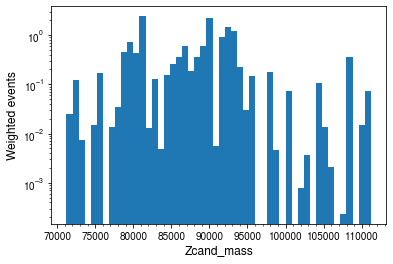

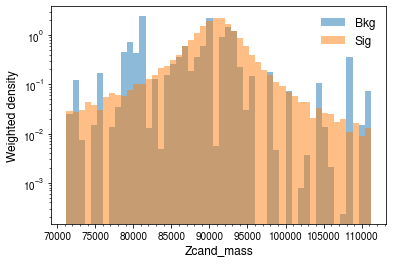

In [7]:
feat = 'Zcand_mass'


bg_source = bg_Zjets

plt.hist(bg_source[feat], weights=bg_source.wgt, bins=50)
plt.yscale('log')

plt.xlabel(feat, fontsize=12)
plt.ylabel('Weighted events', fontsize=12)
plt.minorticks_on()

plt.show()

_, b, _ = plt.hist(bg_source[feat], weights=bg_source.wgt, density=False, bins=50, alpha=0.5, label='Bkg')
plt.hist(sig[feat], weights=sig.wgt, density=False, bins=b, alpha=0.5, label='Sig')

plt.legend(frameon=False, fontsize=12)

plt.xlabel(feat, fontsize=12)
plt.ylabel('Weighted density', fontsize=12)
plt.minorticks_on()

plt.yscale('log')

In [8]:
# train_feats = ['Zlep1_dphi', 'Zlep2_dphi', 'Wlep1_dphi', 'Wlep2_dphi', 'pt_1', 'pt_2', 'Wlep2_pt_sqrt']
# train_feats = ['pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_4l',
#                'Zlep1_dphi', 'Zlep2_dphi', 'Wlep1_dphi', 'Wlep2_dphi', 
#                'Zlep1_phi', 'Zlep2_phi', 'Wlep1_phi', 'Wlep2_phi', 
#                'Zlep1_eta', 'Zlep2_eta', 'Wlep1_eta', 'Wlep2_eta',
#                'Zlep1_pid', 'Zlep2_pid', 'Wlep1_pid', 'Wlep2_pid',
#                'Zlep1_pt', 'Zlep2_pt', 'Wlep1_pt', 'Wlep2_pt',
#                'METSig', 'MET', 'Nlep', 'Njet',
#                'other_mass', 'leptonic_HT', 'total_HT', 'HT', 
#                'SR']

train_feats_raw = sorted([f for f in sig.columns if f not in ['index', 'wgt', 'is_signal', 'Zcand_mass', 'chisq']])

X = pd.concat([sig[train_feats_raw], bg_full[train_feats_raw]], ignore_index=True)

In [9]:
# Normalize inputs for NN training
min_max_scaler = preprocessing.MinMaxScaler()

min_max_scaler.fit(X)

for df in [sig, bg_full] + bg_sources:
    df[train_feats_raw] = min_max_scaler.transform(df[train_feats_raw])

# Signal vs Z + jets

Z + jets events account for

In [10]:
current_bg = bg_Zjets
sum(current_bg.wgt) / sum(bg_full.wgt) * 100

0.8909331116206785

percent of the total background. The amount relative to signal is

In [11]:
print('Number:', len(current_bg)/len(sig) * 100, '%')
print('Weight:', sum(current_bg.wgt)/sum(sig.wgt) * 100, '%')

Number: 0.1984007695545001 %
Weight: 74.84837200397259 %


Now we can scan over different training setups.

In [12]:
np.asarray(train_feats_raw)

array(['HT', 'MET', 'METSig', 'Njet', 'Nlep', 'SR', 'Wlep1_dphi',
       'Wlep1_eta', 'Wlep1_phi', 'Wlep1_pid', 'Wlep1_pt', 'Wlep2_dphi',
       'Wlep2_eta', 'Wlep2_phi', 'Wlep2_pid', 'Wlep2_pt', 'Zlep1_dphi',
       'Zlep1_eta', 'Zlep1_phi', 'Zlep1_pid', 'Zlep1_pt', 'Zlep2_dphi',
       'Zlep2_eta', 'Zlep2_phi', 'Zlep2_pid', 'Zlep2_pt', 'leptonic_HT',
       'mass_4l', 'other_mass', 'pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_4l',
       'total_HT'], dtype='<U11')

In [13]:
train_feat_sets = [train_feats_raw, 
                   [f for f in train_feats_raw if f not in ['Wlep1_phi', 'Wlep2_phi', 'Zlep1_phi', 'Zlep2_phi']],
                   [f for f in train_feats_raw if f not in ['MET', 'METSig']],
                   [f for f in train_feats_raw if f not in ['pt_1', 'pt_2', 'pt_3', 'pt_4']],
                   [f for f in train_feats_raw if f not in ['Njet', 'Nlep']]
                  ]

In [ ]:
EPOCHS = 5000
patience = 500
batch_size = 512
num_nodes = 32
dropout = 0.1
learn_rate = 1e-5

for i, train_feats in enumerate(train_feat_sets):
    print('Running with training features:', train_feats)
    # Save training setup
    with open('models/background_id_models/classifier_Zjets_train_feat_test_' + str(i) + '_setup.txt', 
              'w') as file:
        file.write('Epochs: ' + str(EPOCHS) + '\n')
        file.write('Patience: ' + str(patience) + '\n')
        file.write('Learning rate: ' + str(learn_rate) + '\n')
        file.write('Batch size: ' + str(batch_size) + '\n\n')
        file.write('Training features:\n' + '\n'.join(train_feats))
    
    # Generate train and test samples
    sig_train, sig_test = train_test_split(sig[train_feats + ['wgt']], train_size=0.5, random_state=314)
    bg_train, bg_test = train_test_split(current_bg[train_feats + ['wgt']], train_size=0.5, random_state=314)

    n_sig = sum(sig_train.wgt)
    n_bg = sum(bg_train.wgt)

    x_train_sig = sig_train[train_feats]
    x_train_bg = bg_train[train_feats]

    x_train = pd.concat([x_train_sig, x_train_bg])
    y_train = np.concatenate([np.ones(len(sig_train)), np.zeros(len(bg_train))])
    w_train = pd.Series(np.concatenate([(n_sig + n_bg) / n_sig * sig_train['wgt'], 
                                        (n_sig + n_bg) / n_bg * bg_train['wgt']]))

    n_sig_test = sum(sig_test.wgt)
    n_bg_test = sum(bg_test.wgt)

    x_test = pd.concat([sig_test[train_feats], bg_test[train_feats]])
    y_test = np.concatenate([np.ones(len(sig_test)), np.zeros(len(bg_test))])
    w_test = pd.Series(np.concatenate([(n_sig_test + n_bg_test) / n_sig_test * sig_test['wgt'], 
                                       (n_sig_test + n_bg_test) / n_bg_test * bg_test['wgt']]))
    
    # Generate and fit model
    K.clear_session()
    classifier_Zjets = Sequential()
    classifier_Zjets.add(Dense(num_nodes, input_dim=x_train.shape[1], activation='relu')) 
    classifier_Zjets.add(Dropout(dropout))
    classifier_Zjets.add(Dense(num_nodes, activation='relu'))
    classifier_Zjets.add(Dropout(dropout))
    classifier_Zjets.add(Dense(num_nodes, activation='relu'))
    classifier_Zjets.add(Dropout(dropout))
    classifier_Zjets.add(Dense(1, activation='sigmoid'))

    opt = keras.optimizers.Adam(learning_rate=learn_rate)
    classifier_Zjets.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    # Early stopping
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    history = classifier_Zjets.fit(x_train, y_train, epochs=EPOCHS, batch_size=batch_size,
                                   validation_data=(x_test, y_test, w_test), sample_weight=w_train, 
                                   verbose=1, callbacks=[callback], shuffle=True)
    
    # Save model and history
    classifier_Zjets.save('models/background_id_models/classifier_Zjets_train_feat_test_' + str(i))
    with open('models/background_id_models/classifier_Zjets_train_feat_test_' + str(i) + '_history.pkl', 
              'wb') as file_pi:
        pickle.dump(history.history, file_pi)

Running with training features: ['HT', 'MET', 'METSig', 'Njet', 'Nlep', 'SR', 'Wlep1_dphi', 'Wlep1_eta', 'Wlep1_phi', 'Wlep1_pid', 'Wlep1_pt', 'Wlep2_dphi', 'Wlep2_eta', 'Wlep2_phi', 'Wlep2_pid', 'Wlep2_pt', 'Zlep1_dphi', 'Zlep1_eta', 'Zlep1_phi', 'Zlep1_pid', 'Zlep1_pt', 'Zlep2_dphi', 'Zlep2_eta', 'Zlep2_phi', 'Zlep2_pid', 'Zlep2_pt', 'leptonic_HT', 'mass_4l', 'other_mass', 'pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_4l', 'total_HT']
Epoch 1/5000


2022-01-29 04:33:45.716511: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-29 04:33:45.716898: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3500000000 Hz


 1/66 [..............................] - ETA: 31s - loss: 2.5121e-04 - accuracy: 0.9180

2022-01-29 04:33:46.039518: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


66/66 [==============================] - 1s 8ms/step - loss: 7.7683e-04 - accuracy: 0.9268 - val_loss: 7.4667e-04 - val_accuracy: 0.9929
Epoch 2/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.0287e-04 - accuracy: 0.9269 - val_loss: 7.4665e-04 - val_accuracy: 0.9932
Epoch 3/5000
66/66 [==============================] - 0s 6ms/step - loss: 6.7109e-04 - accuracy: 0.9317 - val_loss: 7.4658e-04 - val_accuracy: 0.9932
Epoch 4/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.9373e-04 - accuracy: 0.9305 - val_loss: 7.4658e-04 - val_accuracy: 0.9932
Epoch 5/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.6203e-04 - accuracy: 0.9277 - val_loss: 7.4652e-04 - val_accuracy: 0.9933
Epoch 6/5000
66/66 [==============================] - 0s 6ms/step - loss: 8.5457e-04 - accuracy: 0.9309 - val_loss: 7.4649e-04 - val_accuracy: 0.9935
Epoch 7/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.5853e-04 - accuracy: 0.9299 - val_los

66/66 [==============================] - 0s 6ms/step - loss: 5.7016e-04 - accuracy: 0.9276 - val_loss: 7.4349e-04 - val_accuracy: 0.9957
Epoch 56/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.8412e-04 - accuracy: 0.9234 - val_loss: 7.4337e-04 - val_accuracy: 0.9956
Epoch 57/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.4844e-04 - accuracy: 0.9203 - val_loss: 7.4339e-04 - val_accuracy: 0.9957
Epoch 58/5000
66/66 [==============================] - 0s 6ms/step - loss: 7.8510e-04 - accuracy: 0.9219 - val_loss: 7.4333e-04 - val_accuracy: 0.9956
Epoch 59/5000
66/66 [==============================] - 0s 6ms/step - loss: 6.6828e-04 - accuracy: 0.9182 - val_loss: 7.4324e-04 - val_accuracy: 0.9957
Epoch 60/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.6935e-04 - accuracy: 0.9188 - val_loss: 7.4319e-04 - val_accuracy: 0.9958
Epoch 61/5000
66/66 [==============================] - 0s 6ms/step - loss: 6.4350e-04 - accuracy: 0.9255 - v

66/66 [==============================] - 0s 6ms/step - loss: 4.6573e-04 - accuracy: 0.8986 - val_loss: 7.4111e-04 - val_accuracy: 0.9955
Epoch 110/5000
66/66 [==============================] - 0s 6ms/step - loss: 6.6981e-04 - accuracy: 0.8942 - val_loss: 7.4110e-04 - val_accuracy: 0.9955
Epoch 111/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.6954e-04 - accuracy: 0.9022 - val_loss: 7.4106e-04 - val_accuracy: 0.9955
Epoch 112/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.9718e-04 - accuracy: 0.8982 - val_loss: 7.4108e-04 - val_accuracy: 0.9953
Epoch 113/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.6069e-04 - accuracy: 0.9021 - val_loss: 7.4107e-04 - val_accuracy: 0.9954
Epoch 114/5000
66/66 [==============================] - 0s 6ms/step - loss: 6.2690e-04 - accuracy: 0.8989 - val_loss: 7.4102e-04 - val_accuracy: 0.9953
Epoch 115/5000
66/66 [==============================] - 0s 6ms/step - loss: 6.6882e-04 - accuracy: 0.89

Epoch 163/5000
66/66 [==============================] - 0s 6ms/step - loss: 7.7383e-04 - accuracy: 0.8737 - val_loss: 7.4056e-04 - val_accuracy: 0.9863
Epoch 164/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.9964e-04 - accuracy: 0.8737 - val_loss: 7.4052e-04 - val_accuracy: 0.9862
Epoch 165/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.8897e-04 - accuracy: 0.8763 - val_loss: 7.4052e-04 - val_accuracy: 0.9861
Epoch 166/5000
66/66 [==============================] - 0s 6ms/step - loss: 6.9441e-04 - accuracy: 0.8730 - val_loss: 7.4052e-04 - val_accuracy: 0.9839
Epoch 167/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.2957e-04 - accuracy: 0.8738 - val_loss: 7.4050e-04 - val_accuracy: 0.9833
Epoch 168/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.2643e-04 - accuracy: 0.8697 - val_loss: 7.4051e-04 - val_accuracy: 0.9831
Epoch 169/5000
66/66 [==============================] - 0s 6ms/step - loss: 7.3360e-04 -

Epoch 217/5000
66/66 [==============================] - 0s 6ms/step - loss: 7.5825e-04 - accuracy: 0.8346 - val_loss: 7.4054e-04 - val_accuracy: 0.9260
Epoch 218/5000
66/66 [==============================] - 0s 6ms/step - loss: 6.1055e-04 - accuracy: 0.8375 - val_loss: 7.4048e-04 - val_accuracy: 0.9250
Epoch 219/5000
66/66 [==============================] - 0s 6ms/step - loss: 7.2263e-04 - accuracy: 0.8388 - val_loss: 7.4046e-04 - val_accuracy: 0.9250
Epoch 220/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.0144e-04 - accuracy: 0.8408 - val_loss: 7.4045e-04 - val_accuracy: 0.9246
Epoch 221/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.8896e-04 - accuracy: 0.8338 - val_loss: 7.4049e-04 - val_accuracy: 0.9233
Epoch 222/5000
66/66 [==============================] - 0s 6ms/step - loss: 6.4220e-04 - accuracy: 0.8369 - val_loss: 7.4047e-04 - val_accuracy: 0.9213
Epoch 223/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.7848e-04 -

Epoch 271/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.9749e-04 - accuracy: 0.8055 - val_loss: 7.4021e-04 - val_accuracy: 0.8501
Epoch 272/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.4517e-04 - accuracy: 0.8062 - val_loss: 7.4020e-04 - val_accuracy: 0.8508
Epoch 273/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.8082e-04 - accuracy: 0.8131 - val_loss: 7.4023e-04 - val_accuracy: 0.8521
Epoch 274/5000
66/66 [==============================] - 0s 6ms/step - loss: 6.6653e-04 - accuracy: 0.8115 - val_loss: 7.4018e-04 - val_accuracy: 0.8499
Epoch 275/5000
66/66 [==============================] - 0s 6ms/step - loss: 7.8094e-04 - accuracy: 0.8093 - val_loss: 7.4012e-04 - val_accuracy: 0.8492
Epoch 276/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.3337e-04 - accuracy: 0.8112 - val_loss: 7.4010e-04 - val_accuracy: 0.8499
Epoch 277/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.8818e-04 -

Epoch 325/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.5585e-04 - accuracy: 0.7857 - val_loss: 7.3883e-04 - val_accuracy: 0.7949
Epoch 326/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.6625e-04 - accuracy: 0.7835 - val_loss: 7.3880e-04 - val_accuracy: 0.7936
Epoch 327/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.8451e-04 - accuracy: 0.7809 - val_loss: 7.3880e-04 - val_accuracy: 0.7948
Epoch 328/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.3512e-04 - accuracy: 0.7874 - val_loss: 7.3877e-04 - val_accuracy: 0.7965
Epoch 329/5000
66/66 [==============================] - 0s 7ms/step - loss: 6.4006e-04 - accuracy: 0.7806 - val_loss: 7.3875e-04 - val_accuracy: 0.7915
Epoch 330/5000
66/66 [==============================] - 0s 6ms/step - loss: 6.4346e-04 - accuracy: 0.7831 - val_loss: 7.3868e-04 - val_accuracy: 0.7926
Epoch 331/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.1479e-04 -

Epoch 379/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.3083e-04 - accuracy: 0.7700 - val_loss: 7.3765e-04 - val_accuracy: 0.7681
Epoch 380/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.9471e-04 - accuracy: 0.7742 - val_loss: 7.3765e-04 - val_accuracy: 0.7709
Epoch 381/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.5760e-04 - accuracy: 0.7703 - val_loss: 7.3764e-04 - val_accuracy: 0.7665
Epoch 382/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.6982e-04 - accuracy: 0.7683 - val_loss: 7.3763e-04 - val_accuracy: 0.7666
Epoch 383/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.1358e-04 - accuracy: 0.7710 - val_loss: 7.3761e-04 - val_accuracy: 0.7663
Epoch 384/5000
66/66 [==============================] - 0s 6ms/step - loss: 6.4942e-04 - accuracy: 0.7699 - val_loss: 7.3761e-04 - val_accuracy: 0.7676
Epoch 385/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.9709e-04 -

Epoch 433/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.8573e-04 - accuracy: 0.7618 - val_loss: 7.3685e-04 - val_accuracy: 0.7547
Epoch 434/5000
66/66 [==============================] - 0s 6ms/step - loss: 6.0697e-04 - accuracy: 0.7589 - val_loss: 7.3683e-04 - val_accuracy: 0.7546
Epoch 435/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.6857e-04 - accuracy: 0.7644 - val_loss: 7.3686e-04 - val_accuracy: 0.7572
Epoch 436/5000
66/66 [==============================] - 0s 7ms/step - loss: 6.7654e-04 - accuracy: 0.7591 - val_loss: 7.3680e-04 - val_accuracy: 0.7546
Epoch 437/5000
66/66 [==============================] - 0s 6ms/step - loss: 6.2210e-04 - accuracy: 0.7570 - val_loss: 7.3681e-04 - val_accuracy: 0.7573
Epoch 438/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.2954e-04 - accuracy: 0.7632 - val_loss: 7.3675e-04 - val_accuracy: 0.7556
Epoch 439/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.6688e-04 -

Epoch 487/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.7986e-04 - accuracy: 0.7679 - val_loss: 7.3600e-04 - val_accuracy: 0.7606
Epoch 488/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.6424e-04 - accuracy: 0.7676 - val_loss: 7.3602e-04 - val_accuracy: 0.7616
Epoch 489/5000
66/66 [==============================] - 0s 7ms/step - loss: 6.5439e-04 - accuracy: 0.7711 - val_loss: 7.3602e-04 - val_accuracy: 0.7612
Epoch 490/5000
66/66 [==============================] - 0s 7ms/step - loss: 6.3584e-04 - accuracy: 0.7682 - val_loss: 7.3596e-04 - val_accuracy: 0.7596
Epoch 491/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.9305e-04 - accuracy: 0.7642 - val_loss: 7.3592e-04 - val_accuracy: 0.7599
Epoch 492/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.8280e-04 - accuracy: 0.7733 - val_loss: 7.3584e-04 - val_accuracy: 0.7595
Epoch 493/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.6230e-04 -

Epoch 541/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.8647e-04 - accuracy: 0.7562 - val_loss: 7.3470e-04 - val_accuracy: 0.7537
Epoch 542/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.9540e-04 - accuracy: 0.7615 - val_loss: 7.3473e-04 - val_accuracy: 0.7545
Epoch 543/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.6518e-04 - accuracy: 0.7608 - val_loss: 7.3486e-04 - val_accuracy: 0.7561
Epoch 544/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.8745e-04 - accuracy: 0.7611 - val_loss: 7.3487e-04 - val_accuracy: 0.7567
Epoch 545/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.4245e-04 - accuracy: 0.7564 - val_loss: 7.3486e-04 - val_accuracy: 0.7558
Epoch 546/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.9083e-04 - accuracy: 0.7602 - val_loss: 7.3477e-04 - val_accuracy: 0.7530
Epoch 547/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.5257e-04 -

Epoch 595/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.4336e-04 - accuracy: 0.7683 - val_loss: 7.3493e-04 - val_accuracy: 0.7667
Epoch 596/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.8697e-04 - accuracy: 0.7706 - val_loss: 7.3506e-04 - val_accuracy: 0.7685
Epoch 597/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.7756e-04 - accuracy: 0.7651 - val_loss: 7.3482e-04 - val_accuracy: 0.7646
Epoch 598/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.2499e-04 - accuracy: 0.7668 - val_loss: 7.3466e-04 - val_accuracy: 0.7628
Epoch 599/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.6346e-04 - accuracy: 0.7578 - val_loss: 7.3460e-04 - val_accuracy: 0.7616
Epoch 600/5000
66/66 [==============================] - 0s 7ms/step - loss: 6.2499e-04 - accuracy: 0.7576 - val_loss: 7.3454e-04 - val_accuracy: 0.7607
Epoch 601/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.1912e-04 -

Epoch 649/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.8124e-04 - accuracy: 0.7816 - val_loss: 7.3588e-04 - val_accuracy: 0.7829
Epoch 650/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.5012e-04 - accuracy: 0.7788 - val_loss: 7.3541e-04 - val_accuracy: 0.7790
Epoch 651/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.0043e-04 - accuracy: 0.7786 - val_loss: 7.3564e-04 - val_accuracy: 0.7787
Epoch 652/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.1597e-04 - accuracy: 0.7701 - val_loss: 7.3547e-04 - val_accuracy: 0.7765
Epoch 653/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.1197e-04 - accuracy: 0.7701 - val_loss: 7.3553e-04 - val_accuracy: 0.7784
Epoch 654/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.5757e-04 - accuracy: 0.7691 - val_loss: 7.3532e-04 - val_accuracy: 0.7762
Epoch 655/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.0180e-04 -

Epoch 703/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.0302e-04 - accuracy: 0.7692 - val_loss: 7.3513e-04 - val_accuracy: 0.7791
Epoch 704/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.7861e-04 - accuracy: 0.7731 - val_loss: 7.3510e-04 - val_accuracy: 0.7793
Epoch 705/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.3612e-04 - accuracy: 0.7744 - val_loss: 7.3499e-04 - val_accuracy: 0.7787
Epoch 706/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.2434e-04 - accuracy: 0.7726 - val_loss: 7.3521e-04 - val_accuracy: 0.7808
Epoch 707/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.0970e-04 - accuracy: 0.7717 - val_loss: 7.3504e-04 - val_accuracy: 0.7795
Epoch 708/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.3302e-04 - accuracy: 0.7740 - val_loss: 7.3548e-04 - val_accuracy: 0.7826
Epoch 709/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.7338e-04 -

Epoch 757/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.8920e-04 - accuracy: 0.7920 - val_loss: 7.3749e-04 - val_accuracy: 0.8001
Epoch 758/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.7354e-04 - accuracy: 0.7937 - val_loss: 7.3723e-04 - val_accuracy: 0.7985
Epoch 759/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.9246e-04 - accuracy: 0.7878 - val_loss: 7.3800e-04 - val_accuracy: 0.8030
Epoch 760/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.7292e-04 - accuracy: 0.7948 - val_loss: 7.3812e-04 - val_accuracy: 0.8044
Epoch 761/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.5114e-04 - accuracy: 0.7915 - val_loss: 7.3802e-04 - val_accuracy: 0.8034
Epoch 762/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.7855e-04 - accuracy: 0.7920 - val_loss: 7.3814e-04 - val_accuracy: 0.8036
Epoch 763/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.2756e-04 -

Epoch 811/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.1780e-04 - accuracy: 0.7930 - val_loss: 7.3880e-04 - val_accuracy: 0.8069
Epoch 812/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.8532e-04 - accuracy: 0.7931 - val_loss: 7.3903e-04 - val_accuracy: 0.8070
Epoch 813/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.2744e-04 - accuracy: 0.7855 - val_loss: 7.3730e-04 - val_accuracy: 0.8002
Epoch 814/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.8757e-04 - accuracy: 0.7832 - val_loss: 7.3605e-04 - val_accuracy: 0.7964
Epoch 815/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.3396e-04 - accuracy: 0.7793 - val_loss: 7.3583e-04 - val_accuracy: 0.7956
Epoch 816/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.3837e-04 - accuracy: 0.7798 - val_loss: 7.3561e-04 - val_accuracy: 0.7950
Epoch 817/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.4240e-04 -

Epoch 865/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.4822e-04 - accuracy: 0.7961 - val_loss: 7.4052e-04 - val_accuracy: 0.8138
Epoch 866/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.9615e-04 - accuracy: 0.7968 - val_loss: 7.4017e-04 - val_accuracy: 0.8134
Epoch 867/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.4434e-04 - accuracy: 0.7992 - val_loss: 7.4039e-04 - val_accuracy: 0.8145
Epoch 868/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.2700e-04 - accuracy: 0.8001 - val_loss: 7.4076e-04 - val_accuracy: 0.8153
Epoch 869/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.1566e-04 - accuracy: 0.7985 - val_loss: 7.4111e-04 - val_accuracy: 0.8156
Epoch 870/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.6700e-04 - accuracy: 0.8038 - val_loss: 7.4074e-04 - val_accuracy: 0.8152
Epoch 871/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.6250e-04 -

Epoch 919/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.2382e-04 - accuracy: 0.8078 - val_loss: 7.4079e-04 - val_accuracy: 0.8191
Epoch 920/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.1953e-04 - accuracy: 0.8050 - val_loss: 7.3962e-04 - val_accuracy: 0.8168
Epoch 921/5000
66/66 [==============================] - 0s 7ms/step - loss: 1.5413e-04 - accuracy: 0.8040 - val_loss: 7.4054e-04 - val_accuracy: 0.8187
Epoch 922/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.9710e-04 - accuracy: 0.7942 - val_loss: 7.4027e-04 - val_accuracy: 0.8188
Epoch 923/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.4639e-04 - accuracy: 0.8009 - val_loss: 7.3956e-04 - val_accuracy: 0.8178
Epoch 924/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.2563e-04 - accuracy: 0.8028 - val_loss: 7.3889e-04 - val_accuracy: 0.8168
Epoch 925/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.1046e-04 -

Epoch 973/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.9599e-04 - accuracy: 0.8033 - val_loss: 7.4099e-04 - val_accuracy: 0.8201
Epoch 974/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.9958e-04 - accuracy: 0.8022 - val_loss: 7.4186e-04 - val_accuracy: 0.8218
Epoch 975/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.1621e-04 - accuracy: 0.7995 - val_loss: 7.4144e-04 - val_accuracy: 0.8216
Epoch 976/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.2268e-04 - accuracy: 0.8027 - val_loss: 7.4190e-04 - val_accuracy: 0.8225
Epoch 977/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.3153e-04 - accuracy: 0.8019 - val_loss: 7.4194e-04 - val_accuracy: 0.8225
Epoch 978/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.9951e-04 - accuracy: 0.8013 - val_loss: 7.4262e-04 - val_accuracy: 0.8234
Epoch 979/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.4386e-04 -

Epoch 1027/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.8635e-04 - accuracy: 0.8106 - val_loss: 7.4541e-04 - val_accuracy: 0.8281
Epoch 1028/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.2407e-04 - accuracy: 0.8109 - val_loss: 7.4512e-04 - val_accuracy: 0.8266
Epoch 1029/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.5470e-04 - accuracy: 0.8111 - val_loss: 7.4478e-04 - val_accuracy: 0.8264
Epoch 1030/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.4144e-04 - accuracy: 0.7994 - val_loss: 7.4426e-04 - val_accuracy: 0.8252
Epoch 1031/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.0375e-04 - accuracy: 0.8083 - val_loss: 7.4385e-04 - val_accuracy: 0.8240
Epoch 1032/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.1198e-04 - accuracy: 0.8055 - val_loss: 7.4509e-04 - val_accuracy: 0.8268
Epoch 1033/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.952

2022-01-29 04:41:12.506094: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/background_id_models/classifier_Zjets_train_feat_test_0/assets
Running with training features: ['HT', 'MET', 'METSig', 'Njet', 'Nlep', 'SR', 'Wlep1_dphi', 'Wlep1_eta', 'Wlep1_pid', 'Wlep1_pt', 'Wlep2_dphi', 'Wlep2_eta', 'Wlep2_pid', 'Wlep2_pt', 'Zlep1_dphi', 'Zlep1_eta', 'Zlep1_pid', 'Zlep1_pt', 'Zlep2_dphi', 'Zlep2_eta', 'Zlep2_pid', 'Zlep2_pt', 'leptonic_HT', 'mass_4l', 'other_mass', 'pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_4l', 'total_HT']
Epoch 1/5000
66/66 [==============================] - 1s 10ms/step - loss: 5.6791e-04 - accuracy: 0.9556 - val_loss: 7.6642e-04 - val_accuracy: 0.9869
Epoch 2/5000
66/66 [==============================] - 0s 6ms/step - loss: 6.8443e-04 - accuracy: 0.9605 - val_loss: 7.6632e-04 - val_accuracy: 0.9868
Epoch 3/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.9285e-04 - accuracy: 0.9593 - val_loss: 7.6624e-04 - val_accuracy: 0.9866
Epoch 4/5000
66/66 [==============================] - 0s 7ms/step

66/66 [==============================] - 0s 7ms/step - loss: 6.1957e-04 - accuracy: 0.9391 - val_loss: 7.6182e-04 - val_accuracy: 0.9764
Epoch 53/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.3371e-04 - accuracy: 0.9390 - val_loss: 7.6174e-04 - val_accuracy: 0.9764
Epoch 54/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.4405e-04 - accuracy: 0.9378 - val_loss: 7.6166e-04 - val_accuracy: 0.9759
Epoch 55/5000
66/66 [==============================] - 0s 7ms/step - loss: 6.3593e-04 - accuracy: 0.9333 - val_loss: 7.6158e-04 - val_accuracy: 0.9757
Epoch 56/5000
66/66 [==============================] - 0s 7ms/step - loss: 6.3949e-04 - accuracy: 0.9385 - val_loss: 7.6152e-04 - val_accuracy: 0.9755
Epoch 57/5000
66/66 [==============================] - 0s 7ms/step - loss: 8.4970e-04 - accuracy: 0.9356 - val_loss: 7.6142e-04 - val_accuracy: 0.9748
Epoch 58/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.7605e-04 - accuracy: 0.9403 - v

66/66 [==============================] - 0s 7ms/step - loss: 5.3582e-04 - accuracy: 0.9258 - val_loss: 7.5639e-04 - val_accuracy: 0.9617
Epoch 107/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.0731e-04 - accuracy: 0.9243 - val_loss: 7.5630e-04 - val_accuracy: 0.9611
Epoch 108/5000
66/66 [==============================] - 0s 7ms/step - loss: 8.3012e-04 - accuracy: 0.9168 - val_loss: 7.5617e-04 - val_accuracy: 0.9606
Epoch 109/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.8739e-04 - accuracy: 0.9185 - val_loss: 7.5610e-04 - val_accuracy: 0.9608
Epoch 110/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.0966e-04 - accuracy: 0.9224 - val_loss: 7.5601e-04 - val_accuracy: 0.9606
Epoch 111/5000
66/66 [==============================] - 0s 7ms/step - loss: 6.7064e-04 - accuracy: 0.9218 - val_loss: 7.5585e-04 - val_accuracy: 0.9598
Epoch 112/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.1332e-04 - accuracy: 0.92

Epoch 160/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.6022e-04 - accuracy: 0.9231 - val_loss: 7.5149e-04 - val_accuracy: 0.9618
Epoch 161/5000
66/66 [==============================] - 0s 7ms/step - loss: 6.1778e-04 - accuracy: 0.9249 - val_loss: 7.5141e-04 - val_accuracy: 0.9620
Epoch 162/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.6414e-04 - accuracy: 0.9241 - val_loss: 7.5131e-04 - val_accuracy: 0.9615
Epoch 163/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.3440e-04 - accuracy: 0.9205 - val_loss: 7.5121e-04 - val_accuracy: 0.9613
Epoch 164/5000
66/66 [==============================] - 0s 7ms/step - loss: 6.1533e-04 - accuracy: 0.9212 - val_loss: 7.5114e-04 - val_accuracy: 0.9615
Epoch 165/5000
66/66 [==============================] - 0s 6ms/step - loss: 6.6057e-04 - accuracy: 0.9235 - val_loss: 7.5105e-04 - val_accuracy: 0.9614
Epoch 166/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.9740e-04 -

Epoch 214/5000
66/66 [==============================] - 0s 7ms/step - loss: 6.4361e-04 - accuracy: 0.9168 - val_loss: 7.4853e-04 - val_accuracy: 0.9553
Epoch 215/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.6393e-04 - accuracy: 0.9219 - val_loss: 7.4850e-04 - val_accuracy: 0.9565
Epoch 216/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.6105e-04 - accuracy: 0.9145 - val_loss: 7.4842e-04 - val_accuracy: 0.9555
Epoch 217/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.3326e-04 - accuracy: 0.9199 - val_loss: 7.4836e-04 - val_accuracy: 0.9560
Epoch 218/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.1118e-04 - accuracy: 0.9220 - val_loss: 7.4831e-04 - val_accuracy: 0.9556
Epoch 219/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.5364e-04 - accuracy: 0.9209 - val_loss: 7.4824e-04 - val_accuracy: 0.9557
Epoch 220/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.8738e-04 -

Epoch 268/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.9781e-04 - accuracy: 0.9247 - val_loss: 7.4662e-04 - val_accuracy: 0.9573
Epoch 269/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.2836e-04 - accuracy: 0.9247 - val_loss: 7.4664e-04 - val_accuracy: 0.9578
Epoch 270/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.0283e-04 - accuracy: 0.9249 - val_loss: 7.4654e-04 - val_accuracy: 0.9572
Epoch 271/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.2955e-04 - accuracy: 0.9259 - val_loss: 7.4662e-04 - val_accuracy: 0.9580
Epoch 272/5000
66/66 [==============================] - 0s 7ms/step - loss: 7.6442e-04 - accuracy: 0.9271 - val_loss: 7.4652e-04 - val_accuracy: 0.9568
Epoch 273/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.5033e-04 - accuracy: 0.9252 - val_loss: 7.4660e-04 - val_accuracy: 0.9576
Epoch 274/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.7970e-04 -

Epoch 322/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.4501e-04 - accuracy: 0.9300 - val_loss: 7.4600e-04 - val_accuracy: 0.9590
Epoch 323/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.8490e-04 - accuracy: 0.9291 - val_loss: 7.4613e-04 - val_accuracy: 0.9598
Epoch 324/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.4574e-04 - accuracy: 0.9301 - val_loss: 7.4609e-04 - val_accuracy: 0.9596
Epoch 325/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.3633e-04 - accuracy: 0.9299 - val_loss: 7.4606e-04 - val_accuracy: 0.9596
Epoch 326/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.2232e-04 - accuracy: 0.9293 - val_loss: 7.4615e-04 - val_accuracy: 0.9605
Epoch 327/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.9001e-04 - accuracy: 0.9302 - val_loss: 7.4620e-04 - val_accuracy: 0.9608
Epoch 328/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.4092e-04 -

Epoch 376/5000
66/66 [==============================] - 0s 7ms/step - loss: 6.7256e-04 - accuracy: 0.9275 - val_loss: 7.4593e-04 - val_accuracy: 0.9571
Epoch 377/5000
66/66 [==============================] - 0s 7ms/step - loss: 7.0984e-04 - accuracy: 0.9303 - val_loss: 7.4597e-04 - val_accuracy: 0.9574
Epoch 378/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.0216e-04 - accuracy: 0.9299 - val_loss: 7.4620e-04 - val_accuracy: 0.9583
Epoch 379/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.1506e-04 - accuracy: 0.9279 - val_loss: 7.4620e-04 - val_accuracy: 0.9581
Epoch 380/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.5552e-04 - accuracy: 0.9282 - val_loss: 7.4606e-04 - val_accuracy: 0.9575
Epoch 381/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.2683e-04 - accuracy: 0.9332 - val_loss: 7.4613e-04 - val_accuracy: 0.9578
Epoch 382/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.4327e-04 -

Epoch 430/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.1455e-04 - accuracy: 0.9279 - val_loss: 7.4610e-04 - val_accuracy: 0.9554
Epoch 431/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.4911e-04 - accuracy: 0.9266 - val_loss: 7.4611e-04 - val_accuracy: 0.9557
Epoch 432/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.2604e-04 - accuracy: 0.9281 - val_loss: 7.4623e-04 - val_accuracy: 0.9557
Epoch 433/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.2386e-04 - accuracy: 0.9296 - val_loss: 7.4634e-04 - val_accuracy: 0.9558
Epoch 434/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.7289e-04 - accuracy: 0.9321 - val_loss: 7.4627e-04 - val_accuracy: 0.9556
Epoch 435/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.7450e-04 - accuracy: 0.9298 - val_loss: 7.4649e-04 - val_accuracy: 0.9563
Epoch 436/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.5012e-04 -

Epoch 484/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.0845e-04 - accuracy: 0.9192 - val_loss: 7.4484e-04 - val_accuracy: 0.9466
Epoch 485/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.8697e-04 - accuracy: 0.9180 - val_loss: 7.4500e-04 - val_accuracy: 0.9470
Epoch 486/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.2957e-04 - accuracy: 0.9207 - val_loss: 7.4516e-04 - val_accuracy: 0.9472
Epoch 487/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.1108e-04 - accuracy: 0.9225 - val_loss: 7.4535e-04 - val_accuracy: 0.9476
Epoch 488/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.5678e-04 - accuracy: 0.9176 - val_loss: 7.4494e-04 - val_accuracy: 0.9466
Epoch 489/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.3977e-04 - accuracy: 0.9167 - val_loss: 7.4507e-04 - val_accuracy: 0.9468
Epoch 490/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.9574e-04 -

Epoch 538/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.9834e-04 - accuracy: 0.9152 - val_loss: 7.4434e-04 - val_accuracy: 0.9425
Epoch 539/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.5038e-04 - accuracy: 0.9180 - val_loss: 7.4400e-04 - val_accuracy: 0.9420
Epoch 540/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.7451e-04 - accuracy: 0.9141 - val_loss: 7.4400e-04 - val_accuracy: 0.9419
Epoch 541/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.2991e-04 - accuracy: 0.9152 - val_loss: 7.4432e-04 - val_accuracy: 0.9425
Epoch 542/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.0692e-04 - accuracy: 0.9159 - val_loss: 7.4422e-04 - val_accuracy: 0.9422
Epoch 543/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.4306e-04 - accuracy: 0.9170 - val_loss: 7.4438e-04 - val_accuracy: 0.9425
Epoch 544/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.1849e-04 -

Epoch 592/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.4174e-04 - accuracy: 0.9076 - val_loss: 7.4271e-04 - val_accuracy: 0.9361
Epoch 593/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.2751e-04 - accuracy: 0.9081 - val_loss: 7.4341e-04 - val_accuracy: 0.9375
Epoch 594/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.8091e-04 - accuracy: 0.9086 - val_loss: 7.4327e-04 - val_accuracy: 0.9370
Epoch 595/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.4138e-04 - accuracy: 0.9091 - val_loss: 7.4328e-04 - val_accuracy: 0.9367
Epoch 596/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.8735e-04 - accuracy: 0.9081 - val_loss: 7.4314e-04 - val_accuracy: 0.9365
Epoch 597/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.5293e-04 - accuracy: 0.9074 - val_loss: 7.4259e-04 - val_accuracy: 0.9357
Epoch 598/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.2990e-04 -

Epoch 646/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.3795e-04 - accuracy: 0.9060 - val_loss: 7.4269e-04 - val_accuracy: 0.9333
Epoch 647/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.2661e-04 - accuracy: 0.9042 - val_loss: 7.4239e-04 - val_accuracy: 0.9327
Epoch 648/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.3260e-04 - accuracy: 0.9040 - val_loss: 7.4230e-04 - val_accuracy: 0.9326
Epoch 649/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.4573e-04 - accuracy: 0.8979 - val_loss: 7.4176e-04 - val_accuracy: 0.9319
Epoch 650/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.3990e-04 - accuracy: 0.9021 - val_loss: 7.4169e-04 - val_accuracy: 0.9318
Epoch 651/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.6804e-04 - accuracy: 0.9040 - val_loss: 7.4170e-04 - val_accuracy: 0.9317
Epoch 652/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.2150e-04 -

Epoch 700/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.9499e-04 - accuracy: 0.8922 - val_loss: 7.3849e-04 - val_accuracy: 0.9225
Epoch 701/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.0290e-04 - accuracy: 0.8860 - val_loss: 7.3819e-04 - val_accuracy: 0.9217
Epoch 702/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.1219e-04 - accuracy: 0.8898 - val_loss: 7.3875e-04 - val_accuracy: 0.9227
Epoch 703/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.3397e-04 - accuracy: 0.8904 - val_loss: 7.3933e-04 - val_accuracy: 0.9238
Epoch 704/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.2075e-04 - accuracy: 0.8911 - val_loss: 7.3925e-04 - val_accuracy: 0.9233
Epoch 705/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.1488e-04 - accuracy: 0.8900 - val_loss: 7.3856e-04 - val_accuracy: 0.9217
Epoch 706/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.4602e-04 -

Epoch 754/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.4371e-04 - accuracy: 0.8794 - val_loss: 7.3773e-04 - val_accuracy: 0.9127
Epoch 755/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.7347e-04 - accuracy: 0.8789 - val_loss: 7.3783e-04 - val_accuracy: 0.9127
Epoch 756/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.2632e-04 - accuracy: 0.8808 - val_loss: 7.3760e-04 - val_accuracy: 0.9121
Epoch 757/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.6496e-04 - accuracy: 0.8824 - val_loss: 7.3868e-04 - val_accuracy: 0.9139
Epoch 758/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.1624e-04 - accuracy: 0.8823 - val_loss: 7.3790e-04 - val_accuracy: 0.9125
Epoch 759/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.1858e-04 - accuracy: 0.8864 - val_loss: 7.3887e-04 - val_accuracy: 0.9140
Epoch 760/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.5609e-04 -

Epoch 808/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.0813e-04 - accuracy: 0.8755 - val_loss: 7.3769e-04 - val_accuracy: 0.9070
Epoch 809/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.2252e-04 - accuracy: 0.8748 - val_loss: 7.3776e-04 - val_accuracy: 0.9071
Epoch 810/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.5339e-04 - accuracy: 0.8752 - val_loss: 7.3773e-04 - val_accuracy: 0.9072
Epoch 811/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.6425e-04 - accuracy: 0.8712 - val_loss: 7.3776e-04 - val_accuracy: 0.9072
Epoch 812/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.6365e-04 - accuracy: 0.8753 - val_loss: 7.3737e-04 - val_accuracy: 0.9068
Epoch 813/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.2413e-04 - accuracy: 0.8775 - val_loss: 7.3699e-04 - val_accuracy: 0.9063
Epoch 814/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.4374e-04 -

Epoch 862/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.3685e-04 - accuracy: 0.8669 - val_loss: 7.3781e-04 - val_accuracy: 0.9017
Epoch 863/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.4104e-04 - accuracy: 0.8679 - val_loss: 7.3678e-04 - val_accuracy: 0.9002
Epoch 864/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.2647e-04 - accuracy: 0.8684 - val_loss: 7.3823e-04 - val_accuracy: 0.9019
Epoch 865/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.3618e-04 - accuracy: 0.8700 - val_loss: 7.3888e-04 - val_accuracy: 0.9024
Epoch 866/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.4404e-04 - accuracy: 0.8702 - val_loss: 7.3854e-04 - val_accuracy: 0.9021
Epoch 867/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.6005e-04 - accuracy: 0.8717 - val_loss: 7.3900e-04 - val_accuracy: 0.9027
Epoch 868/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.4583e-04 -

Epoch 916/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.9263e-04 - accuracy: 0.8623 - val_loss: 7.3848e-04 - val_accuracy: 0.8975
Epoch 917/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.7567e-04 - accuracy: 0.8611 - val_loss: 7.3749e-04 - val_accuracy: 0.8960
Epoch 918/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.9708e-04 - accuracy: 0.8621 - val_loss: 7.3864e-04 - val_accuracy: 0.8975
Epoch 919/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.3649e-04 - accuracy: 0.8622 - val_loss: 7.3857e-04 - val_accuracy: 0.8972
Epoch 920/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.3693e-04 - accuracy: 0.8635 - val_loss: 7.3936e-04 - val_accuracy: 0.8980
Epoch 921/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.6134e-04 - accuracy: 0.8647 - val_loss: 7.3906e-04 - val_accuracy: 0.8975
Epoch 922/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.8966e-04 -

Epoch 970/5000
66/66 [==============================] - 0s 7ms/step - loss: 1.8104e-04 - accuracy: 0.8584 - val_loss: 7.4138e-04 - val_accuracy: 0.8962
Epoch 971/5000
66/66 [==============================] - 0s 7ms/step - loss: 1.8522e-04 - accuracy: 0.8591 - val_loss: 7.4194e-04 - val_accuracy: 0.8966
Epoch 972/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.6339e-04 - accuracy: 0.8633 - val_loss: 7.4022e-04 - val_accuracy: 0.8948
Epoch 973/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.3093e-04 - accuracy: 0.8641 - val_loss: 7.4154e-04 - val_accuracy: 0.8960
Epoch 974/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.6904e-04 - accuracy: 0.8633 - val_loss: 7.4165e-04 - val_accuracy: 0.8960
Epoch 975/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.4038e-04 - accuracy: 0.8643 - val_loss: 7.4137e-04 - val_accuracy: 0.8957
Epoch 976/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.5976e-04 -

Epoch 1024/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.5609e-04 - accuracy: 0.8668 - val_loss: 7.4493e-04 - val_accuracy: 0.8952
Epoch 1025/5000
66/66 [==============================] - 0s 7ms/step - loss: 1.3015e-04 - accuracy: 0.8583 - val_loss: 7.4677e-04 - val_accuracy: 0.8969
Epoch 1026/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.8213e-04 - accuracy: 0.8659 - val_loss: 7.4798e-04 - val_accuracy: 0.8980
Epoch 1027/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.0723e-04 - accuracy: 0.8636 - val_loss: 7.4793e-04 - val_accuracy: 0.8979
Epoch 1028/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.3709e-04 - accuracy: 0.8651 - val_loss: 7.4817e-04 - val_accuracy: 0.8977
Epoch 1029/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.1185e-04 - accuracy: 0.8653 - val_loss: 7.4882e-04 - val_accuracy: 0.8984
Epoch 1030/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.896

66/66 [==============================] - 0s 7ms/step - loss: -3.9139e-05 - accuracy: 0.8613 - val_loss: 7.4936e-04 - val_accuracy: 0.8942
Epoch 1078/5000
66/66 [==============================] - 0s 7ms/step - loss: 1.6948e-04 - accuracy: 0.8603 - val_loss: 7.4952e-04 - val_accuracy: 0.8946
Epoch 1079/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.0727e-04 - accuracy: 0.8618 - val_loss: 7.4874e-04 - val_accuracy: 0.8935
Epoch 1080/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.2746e-04 - accuracy: 0.8628 - val_loss: 7.4897e-04 - val_accuracy: 0.8939
Epoch 1081/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.6375e-04 - accuracy: 0.8636 - val_loss: 7.4906e-04 - val_accuracy: 0.8939
Epoch 1082/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.0860e-04 - accuracy: 0.8599 - val_loss: 7.4926e-04 - val_accuracy: 0.8942
Epoch 1083/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.6404e-04 - accurac

66/66 [==============================] - 0s 7ms/step - loss: 2.5263e-04 - accuracy: 0.8636 - val_loss: 7.5278e-04 - val_accuracy: 0.8952
Epoch 1131/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.1340e-04 - accuracy: 0.8667 - val_loss: 7.5277e-04 - val_accuracy: 0.8954
Epoch 1132/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.5777e-04 - accuracy: 0.8640 - val_loss: 7.5210e-04 - val_accuracy: 0.8945
Epoch 1133/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.5042e-04 - accuracy: 0.8598 - val_loss: 7.5206e-04 - val_accuracy: 0.8947
Epoch 1134/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.6625e-04 - accuracy: 0.8650 - val_loss: 7.5227e-04 - val_accuracy: 0.8948
Epoch 1135/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.5472e-04 - accuracy: 0.8627 - val_loss: 7.5229e-04 - val_accuracy: 0.8949
Epoch 1136/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.8363e-04 - accuracy

66/66 [==============================] - 0s 7ms/step - loss: 3.2587e-04 - accuracy: 0.8635 - val_loss: 7.5498e-04 - val_accuracy: 0.8948
Epoch 1184/5000
66/66 [==============================] - 0s 7ms/step - loss: 1.9784e-04 - accuracy: 0.8620 - val_loss: 7.5568e-04 - val_accuracy: 0.8952
Epoch 1185/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.4506e-04 - accuracy: 0.8617 - val_loss: 7.5560e-04 - val_accuracy: 0.8948
Epoch 1186/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.4177e-04 - accuracy: 0.8628 - val_loss: 7.5533e-04 - val_accuracy: 0.8947
Epoch 1187/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.8980e-04 - accuracy: 0.8624 - val_loss: 7.5404e-04 - val_accuracy: 0.8933
Epoch 1188/5000
66/66 [==============================] - 0s 7ms/step - loss: 1.5656e-04 - accuracy: 0.8606 - val_loss: 7.5349e-04 - val_accuracy: 0.8927
Epoch 1189/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.3788e-04 - accuracy

66/66 [==============================] - 0s 7ms/step - loss: 3.5320e-04 - accuracy: 0.8666 - val_loss: 7.5919e-04 - val_accuracy: 0.8953
Epoch 1237/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.0527e-04 - accuracy: 0.8647 - val_loss: 7.5881e-04 - val_accuracy: 0.8951
Epoch 1238/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.5523e-04 - accuracy: 0.8642 - val_loss: 7.5974e-04 - val_accuracy: 0.8955
Epoch 1239/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.2708e-04 - accuracy: 0.8683 - val_loss: 7.5852e-04 - val_accuracy: 0.8947
Epoch 1240/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.2621e-04 - accuracy: 0.8640 - val_loss: 7.6017e-04 - val_accuracy: 0.8957
Epoch 1241/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.6186e-04 - accuracy: 0.8669 - val_loss: 7.6009e-04 - val_accuracy: 0.8958
Epoch 1242/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.0647e-04 - accuracy

66/66 [==============================] - 0s 7ms/step - loss: 6.3407e-04 - accuracy: 0.6221 - val_loss: 7.6554e-04 - val_accuracy: 0.6462
Epoch 21/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.5965e-04 - accuracy: 0.6167 - val_loss: 7.6550e-04 - val_accuracy: 0.6475
Epoch 22/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.8856e-04 - accuracy: 0.6236 - val_loss: 7.6545e-04 - val_accuracy: 0.6485
Epoch 23/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.7658e-04 - accuracy: 0.6221 - val_loss: 7.6537e-04 - val_accuracy: 0.6497
Epoch 24/5000
66/66 [==============================] - 0s 7ms/step - loss: 6.0478e-04 - accuracy: 0.6219 - val_loss: 7.6534e-04 - val_accuracy: 0.6500
Epoch 25/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.7071e-04 - accuracy: 0.6285 - val_loss: 7.6534e-04 - val_accuracy: 0.6517
Epoch 26/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.6039e-04 - accuracy: 0.6262 - v

66/66 [==============================] - 0s 6ms/step - loss: 5.6165e-04 - accuracy: 0.6437 - val_loss: 7.6337e-04 - val_accuracy: 0.6897
Epoch 75/5000
66/66 [==============================] - 0s 7ms/step - loss: 6.2105e-04 - accuracy: 0.6450 - val_loss: 7.6330e-04 - val_accuracy: 0.6901
Epoch 76/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.1182e-04 - accuracy: 0.6433 - val_loss: 7.6321e-04 - val_accuracy: 0.6934
Epoch 77/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.9499e-04 - accuracy: 0.6397 - val_loss: 7.6303e-04 - val_accuracy: 0.6945
Epoch 78/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.8224e-04 - accuracy: 0.6399 - val_loss: 7.6288e-04 - val_accuracy: 0.6913
Epoch 79/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.4440e-04 - accuracy: 0.6369 - val_loss: 7.6278e-04 - val_accuracy: 0.6869
Epoch 80/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.5665e-04 - accuracy: 0.6388 - v

66/66 [==============================] - 0s 7ms/step - loss: 5.9347e-04 - accuracy: 0.6759 - val_loss: 7.5960e-04 - val_accuracy: 0.7255
Epoch 129/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.3596e-04 - accuracy: 0.6776 - val_loss: 7.5951e-04 - val_accuracy: 0.7268
Epoch 130/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.7085e-04 - accuracy: 0.6825 - val_loss: 7.5944e-04 - val_accuracy: 0.7275
Epoch 131/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.2478e-04 - accuracy: 0.6797 - val_loss: 7.5938e-04 - val_accuracy: 0.7280
Epoch 132/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.7396e-04 - accuracy: 0.6788 - val_loss: 7.5932e-04 - val_accuracy: 0.7292
Epoch 133/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.6677e-04 - accuracy: 0.6872 - val_loss: 7.5922e-04 - val_accuracy: 0.7311
Epoch 134/5000
66/66 [==============================] - 0s 7ms/step - loss: 6.5238e-04 - accuracy: 0.68

Epoch 182/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.3098e-04 - accuracy: 0.7349 - val_loss: 7.5550e-04 - val_accuracy: 0.7901
Epoch 183/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.6675e-04 - accuracy: 0.7363 - val_loss: 7.5544e-04 - val_accuracy: 0.7919
Epoch 184/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.7850e-04 - accuracy: 0.7450 - val_loss: 7.5538e-04 - val_accuracy: 0.7947
Epoch 185/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.2949e-04 - accuracy: 0.7447 - val_loss: 7.5527e-04 - val_accuracy: 0.7953
Epoch 186/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.6488e-04 - accuracy: 0.7447 - val_loss: 7.5527e-04 - val_accuracy: 0.7970
Epoch 187/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.3518e-04 - accuracy: 0.7434 - val_loss: 7.5525e-04 - val_accuracy: 0.8010
Epoch 188/5000
66/66 [==============================] - 0s 7ms/step - loss: 6.0137e-04 -

Epoch 236/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.4122e-04 - accuracy: 0.7696 - val_loss: 7.5088e-04 - val_accuracy: 0.8310
Epoch 237/5000
66/66 [==============================] - 0s 7ms/step - loss: 8.6753e-04 - accuracy: 0.7671 - val_loss: 7.5076e-04 - val_accuracy: 0.8297
Epoch 238/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.9106e-04 - accuracy: 0.7685 - val_loss: 7.5075e-04 - val_accuracy: 0.8329
Epoch 239/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.7786e-04 - accuracy: 0.7751 - val_loss: 7.5059e-04 - val_accuracy: 0.8297
Epoch 240/5000
66/66 [==============================] - 0s 7ms/step - loss: 6.7128e-04 - accuracy: 0.7696 - val_loss: 7.5048e-04 - val_accuracy: 0.8288
Epoch 241/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.8249e-04 - accuracy: 0.7677 - val_loss: 7.5041e-04 - val_accuracy: 0.8270
Epoch 242/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.4766e-04 -

Epoch 290/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.4517e-04 - accuracy: 0.7924 - val_loss: 7.4624e-04 - val_accuracy: 0.8568
Epoch 291/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.3496e-04 - accuracy: 0.7907 - val_loss: 7.4608e-04 - val_accuracy: 0.8553
Epoch 292/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.1844e-04 - accuracy: 0.7909 - val_loss: 7.4608e-04 - val_accuracy: 0.8583
Epoch 293/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.8012e-04 - accuracy: 0.7953 - val_loss: 7.4598e-04 - val_accuracy: 0.8588
Epoch 294/5000
66/66 [==============================] - 0s 7ms/step - loss: 6.4760e-04 - accuracy: 0.7894 - val_loss: 7.4588e-04 - val_accuracy: 0.8588
Epoch 295/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.0532e-04 - accuracy: 0.8000 - val_loss: 7.4585e-04 - val_accuracy: 0.8612
Epoch 296/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.9338e-04 -

Epoch 344/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.7792e-04 - accuracy: 0.8254 - val_loss: 7.4143e-04 - val_accuracy: 0.8864
Epoch 345/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.9484e-04 - accuracy: 0.8245 - val_loss: 7.4127e-04 - val_accuracy: 0.8845
Epoch 346/5000
66/66 [==============================] - 0s 7ms/step - loss: 6.1084e-04 - accuracy: 0.8199 - val_loss: 7.4112e-04 - val_accuracy: 0.8832
Epoch 347/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.9701e-04 - accuracy: 0.8192 - val_loss: 7.4095e-04 - val_accuracy: 0.8831
Epoch 348/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.7218e-04 - accuracy: 0.8273 - val_loss: 7.4085e-04 - val_accuracy: 0.8827
Epoch 349/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.4319e-04 - accuracy: 0.8262 - val_loss: 7.4083e-04 - val_accuracy: 0.8834
Epoch 350/5000
66/66 [==============================] - 0s 7ms/step - loss: 7.3207e-04 -

Epoch 398/5000
66/66 [==============================] - 0s 7ms/step - loss: 7.2490e-04 - accuracy: 0.8392 - val_loss: 7.3699e-04 - val_accuracy: 0.8965
Epoch 399/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.2708e-04 - accuracy: 0.8382 - val_loss: 7.3680e-04 - val_accuracy: 0.8955
Epoch 400/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.3143e-04 - accuracy: 0.8364 - val_loss: 7.3662e-04 - val_accuracy: 0.8943
Epoch 401/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.5500e-04 - accuracy: 0.8312 - val_loss: 7.3623e-04 - val_accuracy: 0.8909
Epoch 402/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.2805e-04 - accuracy: 0.8366 - val_loss: 7.3612e-04 - val_accuracy: 0.8910
Epoch 403/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.6617e-04 - accuracy: 0.8393 - val_loss: 7.3605e-04 - val_accuracy: 0.8918
Epoch 404/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.7902e-04 -

Epoch 452/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.0618e-04 - accuracy: 0.8291 - val_loss: 7.3100e-04 - val_accuracy: 0.8895
Epoch 453/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.9225e-04 - accuracy: 0.8354 - val_loss: 7.3101e-04 - val_accuracy: 0.8897
Epoch 454/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.5849e-04 - accuracy: 0.8333 - val_loss: 7.3095e-04 - val_accuracy: 0.8899
Epoch 455/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.8355e-04 - accuracy: 0.8293 - val_loss: 7.3105e-04 - val_accuracy: 0.8907
Epoch 456/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.4634e-04 - accuracy: 0.8363 - val_loss: 7.3040e-04 - val_accuracy: 0.8867
Epoch 457/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.4716e-04 - accuracy: 0.8304 - val_loss: 7.3038e-04 - val_accuracy: 0.8871
Epoch 458/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.9145e-04 -

Epoch 506/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.4325e-04 - accuracy: 0.8341 - val_loss: 7.2606e-04 - val_accuracy: 0.8926
Epoch 507/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.7862e-04 - accuracy: 0.8305 - val_loss: 7.2627e-04 - val_accuracy: 0.8941
Epoch 508/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.1680e-04 - accuracy: 0.8404 - val_loss: 7.2620e-04 - val_accuracy: 0.8941
Epoch 509/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.7427e-04 - accuracy: 0.8392 - val_loss: 7.2585e-04 - val_accuracy: 0.8924
Epoch 510/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.0129e-04 - accuracy: 0.8346 - val_loss: 7.2591e-04 - val_accuracy: 0.8934
Epoch 511/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.6773e-04 - accuracy: 0.8355 - val_loss: 7.2573e-04 - val_accuracy: 0.8927
Epoch 512/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.2492e-04 -

Epoch 560/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.1084e-04 - accuracy: 0.8369 - val_loss: 7.2221e-04 - val_accuracy: 0.8936
Epoch 561/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.1693e-04 - accuracy: 0.8386 - val_loss: 7.2201e-04 - val_accuracy: 0.8931
Epoch 562/5000
66/66 [==============================] - 0s 7ms/step - loss: 6.0256e-04 - accuracy: 0.8404 - val_loss: 7.2199e-04 - val_accuracy: 0.8942
Epoch 563/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.5404e-04 - accuracy: 0.8429 - val_loss: 7.2206e-04 - val_accuracy: 0.8947
Epoch 564/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.8410e-04 - accuracy: 0.8391 - val_loss: 7.2154e-04 - val_accuracy: 0.8936
Epoch 565/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.9028e-04 - accuracy: 0.8362 - val_loss: 7.2143e-04 - val_accuracy: 0.8935
Epoch 566/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.9268e-04 -

Epoch 614/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.9928e-04 - accuracy: 0.8284 - val_loss: 7.1383e-04 - val_accuracy: 0.8815
Epoch 615/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.0256e-04 - accuracy: 0.8322 - val_loss: 7.1421e-04 - val_accuracy: 0.8831
Epoch 616/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.6588e-04 - accuracy: 0.8282 - val_loss: 7.1372e-04 - val_accuracy: 0.8818
Epoch 617/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.1265e-04 - accuracy: 0.8324 - val_loss: 7.1409e-04 - val_accuracy: 0.8832
Epoch 618/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.1372e-04 - accuracy: 0.8339 - val_loss: 7.1422e-04 - val_accuracy: 0.8837
Epoch 619/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.4930e-04 - accuracy: 0.8288 - val_loss: 7.1420e-04 - val_accuracy: 0.8840
Epoch 620/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.2446e-04 -

Epoch 668/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.5042e-04 - accuracy: 0.8211 - val_loss: 7.0624e-04 - val_accuracy: 0.8722
Epoch 669/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.5345e-04 - accuracy: 0.8236 - val_loss: 7.0645e-04 - val_accuracy: 0.8734
Epoch 670/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.6649e-04 - accuracy: 0.8270 - val_loss: 7.0659e-04 - val_accuracy: 0.8741
Epoch 671/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.4760e-04 - accuracy: 0.8241 - val_loss: 7.0673e-04 - val_accuracy: 0.8747
Epoch 672/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.5440e-04 - accuracy: 0.8199 - val_loss: 7.0660e-04 - val_accuracy: 0.8747
Epoch 673/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.1544e-04 - accuracy: 0.8243 - val_loss: 7.0654e-04 - val_accuracy: 0.8748
Epoch 674/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.1230e-04 -

Epoch 722/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.7212e-04 - accuracy: 0.8380 - val_loss: 7.0704e-04 - val_accuracy: 0.8854
Epoch 723/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.5736e-04 - accuracy: 0.8385 - val_loss: 7.0624e-04 - val_accuracy: 0.8843
Epoch 724/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.8249e-04 - accuracy: 0.8323 - val_loss: 7.0685e-04 - val_accuracy: 0.8859
Epoch 725/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.2518e-04 - accuracy: 0.8367 - val_loss: 7.0689e-04 - val_accuracy: 0.8863
Epoch 726/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.1034e-04 - accuracy: 0.8357 - val_loss: 7.0753e-04 - val_accuracy: 0.8878
Epoch 727/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.8269e-04 - accuracy: 0.8410 - val_loss: 7.0777e-04 - val_accuracy: 0.8886
Epoch 728/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.7304e-04 -

Epoch 776/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.7611e-04 - accuracy: 0.8321 - val_loss: 6.9996e-04 - val_accuracy: 0.8782
Epoch 777/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.8429e-04 - accuracy: 0.8336 - val_loss: 6.9925e-04 - val_accuracy: 0.8769
Epoch 778/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.3907e-04 - accuracy: 0.8283 - val_loss: 6.9987e-04 - val_accuracy: 0.8782
Epoch 779/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.0046e-04 - accuracy: 0.8286 - val_loss: 6.9950e-04 - val_accuracy: 0.8777
Epoch 780/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.1557e-04 - accuracy: 0.8331 - val_loss: 6.9994e-04 - val_accuracy: 0.8783
Epoch 781/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.4442e-04 - accuracy: 0.8280 - val_loss: 6.9967e-04 - val_accuracy: 0.8780
Epoch 782/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.0456e-04 -

Epoch 830/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.9806e-04 - accuracy: 0.8324 - val_loss: 6.9998e-04 - val_accuracy: 0.8819
Epoch 831/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.0763e-04 - accuracy: 0.8354 - val_loss: 6.9973e-04 - val_accuracy: 0.8818
Epoch 832/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.9123e-04 - accuracy: 0.8319 - val_loss: 6.9955e-04 - val_accuracy: 0.8815
Epoch 833/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.3289e-04 - accuracy: 0.8361 - val_loss: 6.9893e-04 - val_accuracy: 0.8804
Epoch 834/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.2664e-04 - accuracy: 0.8395 - val_loss: 7.0018e-04 - val_accuracy: 0.8822
Epoch 835/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.3319e-04 - accuracy: 0.8428 - val_loss: 7.0108e-04 - val_accuracy: 0.8840
Epoch 836/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.1376e-04 -

Epoch 884/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.6158e-04 - accuracy: 0.8401 - val_loss: 6.9844e-04 - val_accuracy: 0.8816
Epoch 885/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.7170e-04 - accuracy: 0.8378 - val_loss: 6.9944e-04 - val_accuracy: 0.8828
Epoch 886/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.2778e-04 - accuracy: 0.8403 - val_loss: 6.9956e-04 - val_accuracy: 0.8830
Epoch 887/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.5852e-04 - accuracy: 0.8425 - val_loss: 6.9892e-04 - val_accuracy: 0.8822
Epoch 888/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.4573e-04 - accuracy: 0.8411 - val_loss: 6.9963e-04 - val_accuracy: 0.8834
Epoch 889/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.2511e-04 - accuracy: 0.8387 - val_loss: 7.0011e-04 - val_accuracy: 0.8837
Epoch 890/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.9641e-04 -

Epoch 938/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.8693e-04 - accuracy: 0.8369 - val_loss: 6.9820e-04 - val_accuracy: 0.8795
Epoch 939/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.2553e-04 - accuracy: 0.8429 - val_loss: 6.9960e-04 - val_accuracy: 0.8810
Epoch 940/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.4315e-04 - accuracy: 0.8391 - val_loss: 6.9960e-04 - val_accuracy: 0.8809
Epoch 941/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.0460e-04 - accuracy: 0.8369 - val_loss: 6.9736e-04 - val_accuracy: 0.8786
Epoch 942/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.8443e-04 - accuracy: 0.8401 - val_loss: 6.9752e-04 - val_accuracy: 0.8787
Epoch 943/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.3473e-04 - accuracy: 0.8375 - val_loss: 6.9800e-04 - val_accuracy: 0.8792
Epoch 944/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.5417e-04 -

Epoch 992/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.0849e-04 - accuracy: 0.8474 - val_loss: 7.0343e-04 - val_accuracy: 0.8870
Epoch 993/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.9370e-04 - accuracy: 0.8467 - val_loss: 7.0210e-04 - val_accuracy: 0.8855
Epoch 994/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.0460e-04 - accuracy: 0.8472 - val_loss: 7.0193e-04 - val_accuracy: 0.8854
Epoch 995/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.9249e-04 - accuracy: 0.8429 - val_loss: 7.0107e-04 - val_accuracy: 0.8840
Epoch 996/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.7874e-04 - accuracy: 0.8466 - val_loss: 7.0203e-04 - val_accuracy: 0.8853
Epoch 997/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.0349e-04 - accuracy: 0.8423 - val_loss: 6.9793e-04 - val_accuracy: 0.8811
Epoch 998/5000
66/66 [==============================] - 0s 7ms/step - loss: 5.0392e-04 -

66/66 [==============================] - 0s 7ms/step - loss: 3.1012e-04 - accuracy: 0.8441 - val_loss: 6.9814e-04 - val_accuracy: 0.8818
Epoch 1046/5000
66/66 [==============================] - 0s 7ms/step - loss: 1.9943e-04 - accuracy: 0.8437 - val_loss: 6.9963e-04 - val_accuracy: 0.8832
Epoch 1047/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.2214e-04 - accuracy: 0.8457 - val_loss: 7.0008e-04 - val_accuracy: 0.8840
Epoch 1048/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.5613e-04 - accuracy: 0.8484 - val_loss: 7.0160e-04 - val_accuracy: 0.8856
Epoch 1049/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.5957e-04 - accuracy: 0.8482 - val_loss: 7.0166e-04 - val_accuracy: 0.8857
Epoch 1050/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.2702e-04 - accuracy: 0.8472 - val_loss: 7.0269e-04 - val_accuracy: 0.8867
Epoch 1051/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.2830e-04 - accuracy

66/66 [==============================] - 0s 7ms/step - loss: 3.2067e-04 - accuracy: 0.8428 - val_loss: 7.0301e-04 - val_accuracy: 0.8857
Epoch 1099/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.1838e-04 - accuracy: 0.8499 - val_loss: 7.0336e-04 - val_accuracy: 0.8859
Epoch 1100/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.5949e-04 - accuracy: 0.8456 - val_loss: 7.0409e-04 - val_accuracy: 0.8867
Epoch 1101/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.6925e-04 - accuracy: 0.8506 - val_loss: 7.0493e-04 - val_accuracy: 0.8874
Epoch 1102/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.2594e-04 - accuracy: 0.8492 - val_loss: 7.0637e-04 - val_accuracy: 0.8889
Epoch 1103/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.7234e-04 - accuracy: 0.8510 - val_loss: 7.0670e-04 - val_accuracy: 0.8891
Epoch 1104/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.6554e-04 - accuracy

66/66 [==============================] - 0s 7ms/step - loss: 3.7394e-04 - accuracy: 0.8503 - val_loss: 7.0449e-04 - val_accuracy: 0.8867
Epoch 1152/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.2612e-04 - accuracy: 0.8517 - val_loss: 7.0580e-04 - val_accuracy: 0.8878
Epoch 1153/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.1098e-04 - accuracy: 0.8473 - val_loss: 7.0667e-04 - val_accuracy: 0.8887
Epoch 1154/5000
66/66 [==============================] - 0s 7ms/step - loss: 4.3482e-04 - accuracy: 0.8524 - val_loss: 7.0680e-04 - val_accuracy: 0.8891
Epoch 1155/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.1406e-04 - accuracy: 0.8516 - val_loss: 7.0754e-04 - val_accuracy: 0.8896
Epoch 1156/5000
66/66 [==============================] - 0s 7ms/step - loss: 3.1308e-04 - accuracy: 0.8541 - val_loss: 7.0756e-04 - val_accuracy: 0.8896
Epoch 1157/5000
66/66 [==============================] - 0s 7ms/step - loss: 2.8824e-04 - accuracy